In [54]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

import albumentations as A

import rasterio
from rasterio.windows import Window



In [55]:
def rle_encode(im):                                    
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]                                  
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape = (512, 512)):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype = int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order = 'F')

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torchvision
from torchvision import transforms as T


In [57]:
EPOCHES = 50
BATCH_SIZE = 32
IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(6)
trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
    #A.RandomSizedCrop(min_height=224, min_width=224, height=IMAGE_SIZE, width=IMAGE_SIZE, p=0.5),
    #A.ColorJitter(),
])

In [58]:

# 获取当前使用的GPU的索引
current_device_index = torch.cuda.current_device()
print(f"当前使用的GPU索引是: {current_device_index}")

当前使用的GPU索引是: 6


In [59]:
class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode = False):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.test_mode = test_mode

        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101])
        ])

    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if not self.test_mode:
            mask = rle_decode(self.rles[index])
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][None]
        else:
            return self.as_tensor(img), ''
        
    def __len__(self):
        return self.len

In [60]:
train_mask = pd.read_csv('./dataSets/train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: './dataSets/train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0]) 

True


In [61]:
dataSet = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)

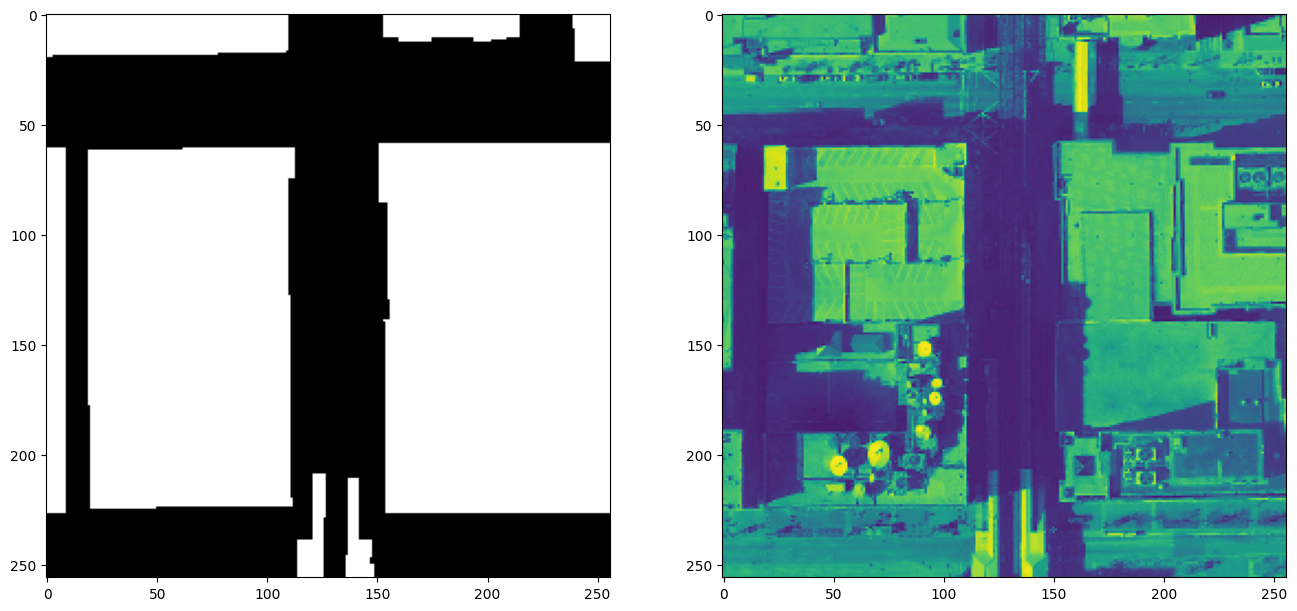

In [62]:
image, mask = dataSet[0]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0])


In [63]:
valid_idx, train_idx = [], []
for i in range(len(dataSet)):
    if i % 7 == 0:
        valid_idx.append(i)
    else:
        train_idx.append(i)
    # elif i % 7 == 1:
    #     train_idx.append(i)

train_ds = D.Subset(dataSet, train_idx)
valid_ds = D.Subset(dataSet, valid_idx)

loader = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
vloader = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
print(len(train_ds), len(valid_ds))


25714 4286


In [64]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
    return np.array(losses).mean()

In [65]:
model = get_model()
model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay=1e-3)

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1, dims=(-2, -1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims

    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)

        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()


def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8 * bce + 0.2 * dice

In [66]:


# 列出所有GPU的索引和名字
print("所有可用的GPU:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 获取当前使用的GPU的索引
current_device_index = torch.cuda.current_device()
print(f"\n当前使用的GPU索引是: {current_device_index}")

所有可用的GPU:
GPU 0: NVIDIA GeForce RTX 3090
GPU 1: NVIDIA GeForce RTX 3090
GPU 2: NVIDIA GeForce RTX 3090
GPU 3: NVIDIA GeForce RTX 3090
GPU 4: NVIDIA GeForce RTX 3090
GPU 5: NVIDIA GeForce RTX 3090
GPU 6: NVIDIA GeForce RTX 3090

当前使用的GPU索引是: 6


In [67]:
header = r'''
         Train   | Valid
Epoch   |  Loss  |  Loss  | Time, m 
'''
#           Epoch       metrics                time
raw_line = '{:6d}' + '\u2502{:7.3f}' * 2 + '\u2502{:6.2f}'
print(header)

EPOCHES = 50
best_loss = 10
for epoch in range(1, EPOCHES + 1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm_notebook(loader):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss, (time.time() - start_time) / 60**1))
    losses = []         

    if vloss < best_loss:
        best_loss = vloss
        torch.save(model.state_dict(), 'model_best.pth')


         Train   | Valid
Epoch   |  Loss  |  Loss  | Time, m 



  0%|          | 0/804 [00:00<?, ?it/s]

     1│  0.257│  0.207│  7.49


  0%|          | 0/804 [00:00<?, ?it/s]

     2│  0.192│  0.167│  7.50


  0%|          | 0/804 [00:00<?, ?it/s]

     3│  0.164│  0.159│  7.46


  0%|          | 0/804 [00:00<?, ?it/s]

     4│  0.159│  0.155│  7.42


  0%|          | 0/804 [00:00<?, ?it/s]

     5│  0.152│  0.150│  7.47


  0%|          | 0/804 [00:00<?, ?it/s]

     6│  0.151│  0.157│  7.41


  0%|          | 0/804 [00:00<?, ?it/s]

     7│  0.148│  0.151│  7.43


  0%|          | 0/804 [00:00<?, ?it/s]

     8│  0.144│  0.146│  7.36


  0%|          | 0/804 [00:00<?, ?it/s]

     9│  0.141│  0.147│  7.42


  0%|          | 0/804 [00:00<?, ?it/s]

    10│  0.141│  0.146│  7.44


  0%|          | 0/804 [00:00<?, ?it/s]

    11│  0.139│  0.142│  7.46


  0%|          | 0/804 [00:00<?, ?it/s]

    12│  0.137│  0.141│  7.45


  0%|          | 0/804 [00:00<?, ?it/s]

    13│  0.137│  0.137│  7.47


  0%|          | 0/804 [00:00<?, ?it/s]

    14│  0.134│  0.141│  7.42


  0%|          | 0/804 [00:00<?, ?it/s]

    15│  0.133│  0.135│  7.47


  0%|          | 0/804 [00:00<?, ?it/s]

    16│  0.131│  0.138│  7.45


  0%|          | 0/804 [00:00<?, ?it/s]

    17│  0.130│  0.135│  7.51


  0%|          | 0/804 [00:00<?, ?it/s]

    18│  0.130│  0.145│  7.50


  0%|          | 0/804 [00:00<?, ?it/s]

    19│  0.128│  0.134│  7.50


  0%|          | 0/804 [00:00<?, ?it/s]

    20│  0.128│  0.131│  7.47


  0%|          | 0/804 [00:00<?, ?it/s]

    21│  0.125│  0.133│  7.50


  0%|          | 0/804 [00:00<?, ?it/s]

    22│  0.125│  0.131│  7.53


  0%|          | 0/804 [00:00<?, ?it/s]

    23│  0.124│  0.131│  7.50


  0%|          | 0/804 [00:00<?, ?it/s]

    24│  0.123│  0.130│  7.47


  0%|          | 0/804 [00:00<?, ?it/s]

    25│  0.123│  0.131│  7.47


  0%|          | 0/804 [00:00<?, ?it/s]

    26│  0.123│  0.134│  7.48


  0%|          | 0/804 [00:00<?, ?it/s]

    27│  0.121│  0.127│  7.47


  0%|          | 0/804 [00:00<?, ?it/s]

    28│  0.118│  0.129│  7.52


  0%|          | 0/804 [00:00<?, ?it/s]

    29│  0.119│  0.129│  7.52


  0%|          | 0/804 [00:00<?, ?it/s]

    30│  0.119│  0.127│  7.51


  0%|          | 0/804 [00:00<?, ?it/s]

    31│  0.117│  0.126│  7.51


  0%|          | 0/804 [00:00<?, ?it/s]

    32│  0.118│  0.125│  7.54


  0%|          | 0/804 [00:00<?, ?it/s]

    33│  0.115│  0.124│  7.48


  0%|          | 0/804 [00:00<?, ?it/s]

    34│  0.114│  0.125│  7.50


  0%|          | 0/804 [00:00<?, ?it/s]

    35│  0.115│  0.157│  7.49


  0%|          | 0/804 [00:00<?, ?it/s]

    36│  0.115│  0.126│  7.50


  0%|          | 0/804 [00:00<?, ?it/s]

    37│  0.112│  0.124│  7.50


  0%|          | 0/804 [00:00<?, ?it/s]

    38│  0.113│  0.122│  7.50


  0%|          | 0/804 [00:00<?, ?it/s]

    39│  0.113│  0.124│  7.49


  0%|          | 0/804 [00:00<?, ?it/s]

    40│  0.111│  0.121│  7.48


  0%|          | 0/804 [00:00<?, ?it/s]

    41│  0.110│  0.121│  7.49


  0%|          | 0/804 [00:00<?, ?it/s]

    42│  0.110│  0.122│  7.48


  0%|          | 0/804 [00:00<?, ?it/s]

    43│  0.110│  0.121│  7.44


  0%|          | 0/804 [00:00<?, ?it/s]

    44│  0.109│  0.122│  7.43


  0%|          | 0/804 [00:00<?, ?it/s]

    45│  0.107│  0.119│  7.48


  0%|          | 0/804 [00:00<?, ?it/s]

    46│  0.109│  0.123│  7.47


  0%|          | 0/804 [00:00<?, ?it/s]

    47│  0.108│  0.118│  7.49


  0%|          | 0/804 [00:00<?, ?it/s]

    48│  0.106│  0.119│  7.44


  0%|          | 0/804 [00:00<?, ?it/s]

    49│  0.106│  0.122│  7.58


  0%|          | 0/804 [00:00<?, ?it/s]

    50│  0.105│  0.121│  7.49


In [68]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

subm = []

model.load_state_dict(torch.load("./model_best.pth"))
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [69]:
test_mask = pd.read_csv('./dataSets/test_a_samplesubmit.csv', sep = '\t', names=['name', 'mask'])
test_mask['name'] = test_mask['name'].apply(lambda x: './dataSets/test_a/' + x)

for idx, name in enumerate(tqdm_notebook(test_mask['name'].iloc[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score = model(image)['out'][0][0]
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))

    subm.append([name.split('/')[-1], rle_encode(score_sigmoid)])

  0%|          | 0/2500 [00:00<?, ?it/s]

In [70]:
subm = pd.DataFrame(subm)
subm.to_csv('./tmp.csv', index=None, header=None, sep='\t')

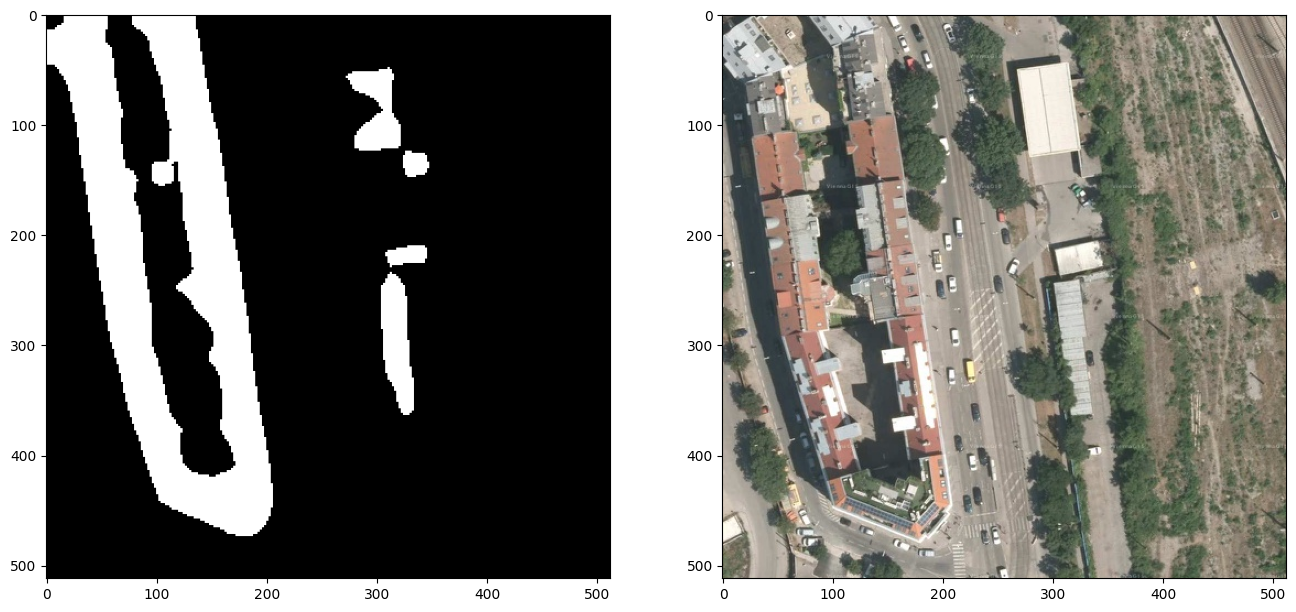

In [71]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(rle_decode(subm[1].fillna('').iloc[0]), cmap='gray')
plt.subplot(122)
plt.imshow(cv2.imread('./dataSets/test_a/' + subm[0].iloc[0]))
